# Kenar Entertainment Sentiment Analysis

## Set up environment

In [19]:
import os
from dotenv import find_dotenv, load_dotenv
import tweepy
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import nltk
import matplotlib.pyplot as plt


nltk.download('vader_lexicon')
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
API_KEY = os.getenv("API_KEY")
API_KEY_SECRET = os.getenv("API_KEY_SECRET")
BEARER_TOKEN = os.getenv("BEARER_TOKEN")
ACCESS_TOKEN = os.getenv("ACCESS_TOKEN")
ACCESS_TOKEN_SECRET = os.getenv("ACCESS_TOKEN_SECRET")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Authentication

### API v2.0

In [23]:
api2 = tweepy.Client(bearer_token=BEARER_TOKEN)

query = '#CrazyKennar -is:retweet lang:en'

paginator = tweepy.Paginator(
    api2.search_recent_tweets,
    query = query,
    max_results=100,
    limit=10
)

tweet_list = []

for tweet in paginator.flatten():
    tweet_list.append(tweet)

In [24]:
tweet_list_df = pd.DataFrame(tweet_list)
tweet_list_df = pd.DataFrame(tweet_list_df['text'])
tweet_list_df.head(5)

,text
0,@crazy_kennar asha wa plug🤣🤣.... We've got ama...
1,Hp Elitebook 840 G3\nIntel®️ Core™️ i5 6th gen...
2,How well do you know #CrazyKennar?\n\nFull Vid...


## Data Preprocessing

In [25]:
from util import preprocess_tweet
cleaned_tweets = []

for tweet in tweet_list_df['text']:
  cleaned_tweet = preprocess_tweet(tweet)
  cleaned_tweets.append(cleaned_tweet)

In [26]:
tweet_list_df['cleaned'] = pd.DataFrame(cleaned_tweets)
tweet_list_df.head(5)

,text,cleaned
0,@crazy_kennar asha wa plug🤣🤣.... We've got ama...,kennar asha wa plug we ve got amazing offers ...
1,Hp Elitebook 840 G3\nIntel®️ Core™️ i5 6th gen...,hp elitebook 840 g3 intel core i5 6th generati...
2,How well do you know #CrazyKennar?\n\nFull Vid...,how well do you know crazykennar full video on...


## Generate Sentiment Labels

In [27]:
#Calculating Negative, Positive, Neutral and Compound values

tweet_list_df[['polarity', 'subjectivity']] = tweet_list_df['cleaned'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tweet_list_df['cleaned'].items():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if comp <= -0.05:
        tweet_list_df.loc[index, 'sentiment'] = "negative"
    elif comp >= 0.05:
        tweet_list_df.loc[index, 'sentiment'] = "positive"
    else:
        tweet_list_df.loc[index, 'sentiment'] = "neutral"
    tweet_list_df.loc[index, 'neg'] = neg
    tweet_list_df.loc[index, 'neu'] = neu
    tweet_list_df.loc[index, 'pos'] = pos
    tweet_list_df.loc[index, 'compound'] = comp

tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,@crazy_kennar asha wa plug🤣🤣.... We've got ama...,kennar asha wa plug we ve got amazing offers ...,0.233333,0.433333,positive,0.048,0.758,0.194,0.7003
1,Hp Elitebook 840 G3\nIntel®️ Core™️ i5 6th gen...,hp elitebook 840 g3 intel core i5 6th generati...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,How well do you know #CrazyKennar?\n\nFull Vid...,how well do you know crazykennar full video on...,0.350000,0.550000,positive,0.000,0.826,0.174,0.2732


## Sentiment Visualization

In [28]:
#Creating new data frames for all sentiments (positive, negative and neutral)

tweet_list_df_negative = tweet_list_df[tweet_list_df["sentiment"]=="negative"]
tweet_list_df_positive = tweet_list_df[tweet_list_df["sentiment"]=="positive"]
tweet_list_df_neutral = tweet_list_df[tweet_list_df["sentiment"]=="neutral"]

### Donut Chart

In [29]:
from util import count_values_in_column

#Count_values for sentiment
count_values_in_column(tweet_list_df,"sentiment")

,Total,Percentage
positive,2,66.67
neutral,1,33.33


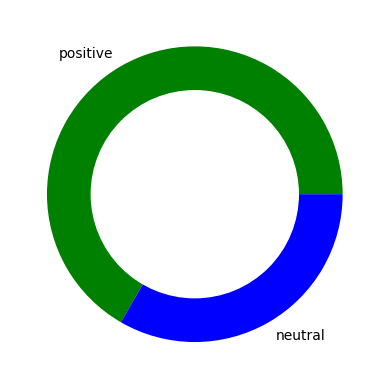

In [30]:
# create data for Pie Chart
pichart = count_values_in_column(tweet_list_df,"sentiment")

names= pichart.index
size=pichart["Percentage"]

# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### World Cloud

Word Cloud Saved Successfully (all)


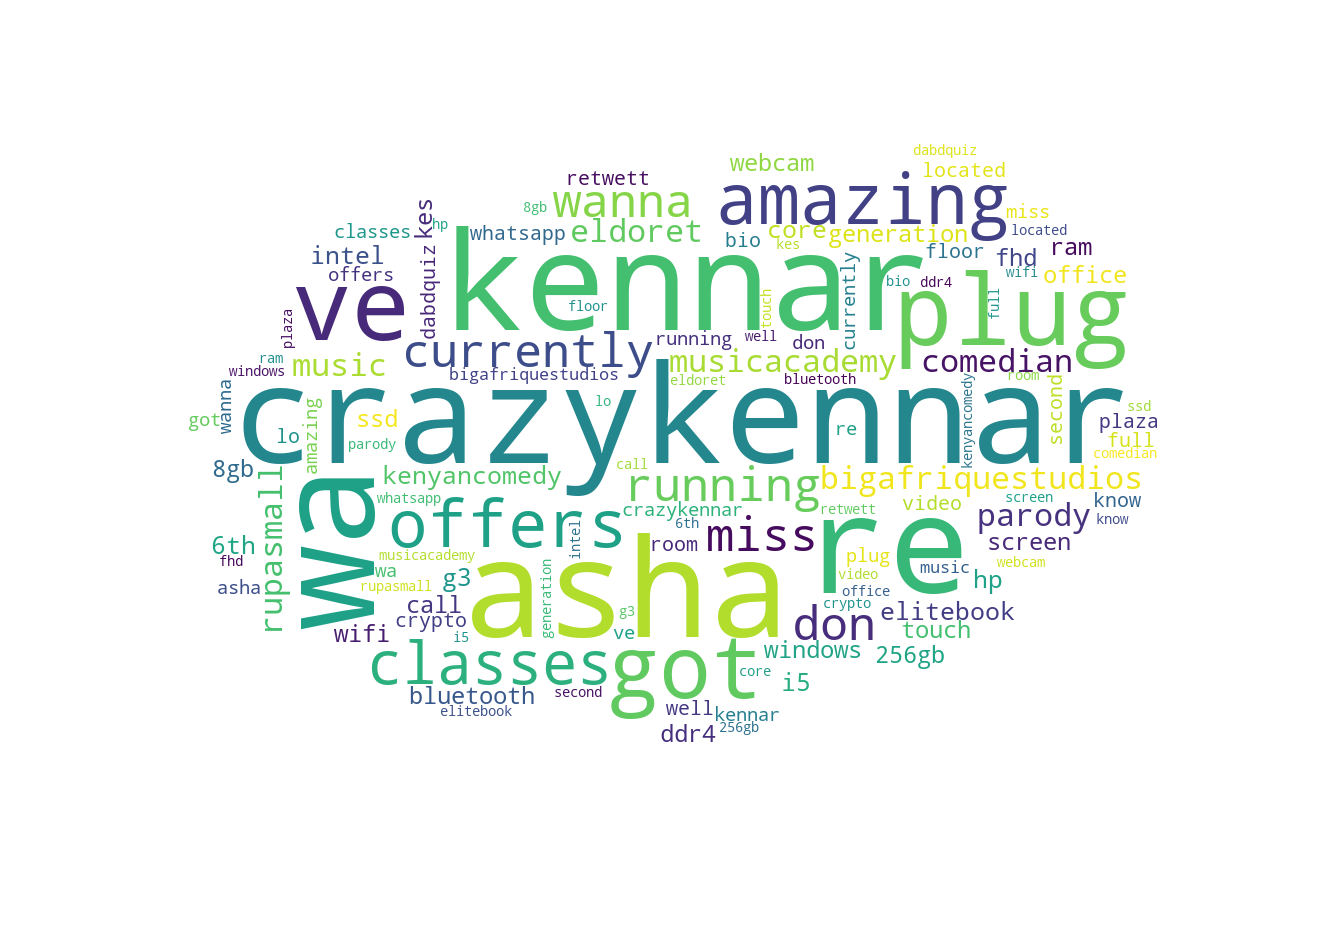

Word Cloud Saved Successfully (positive)


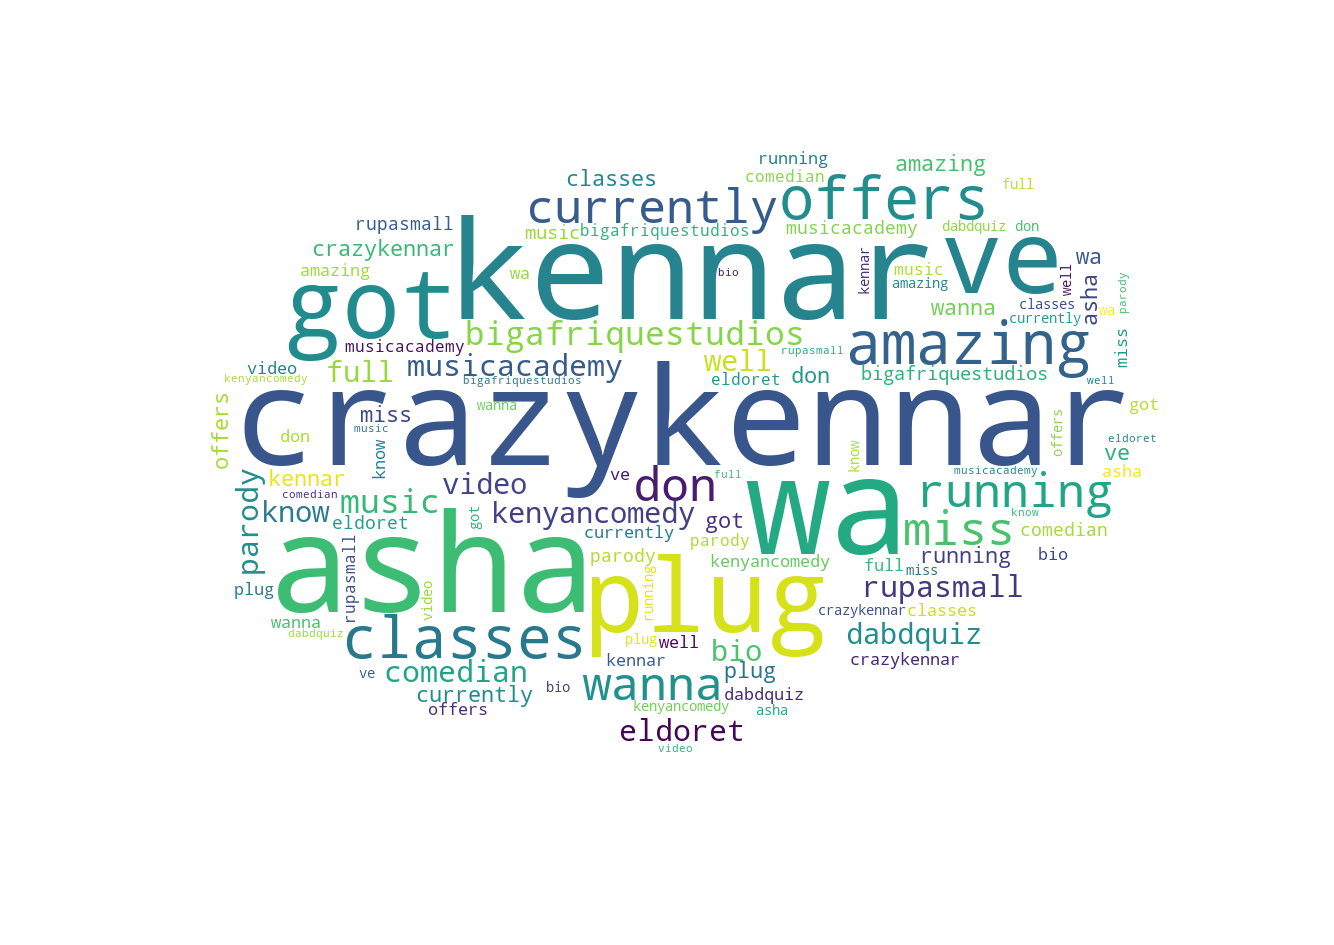

Word Cloud Saved Successfully (neutral)


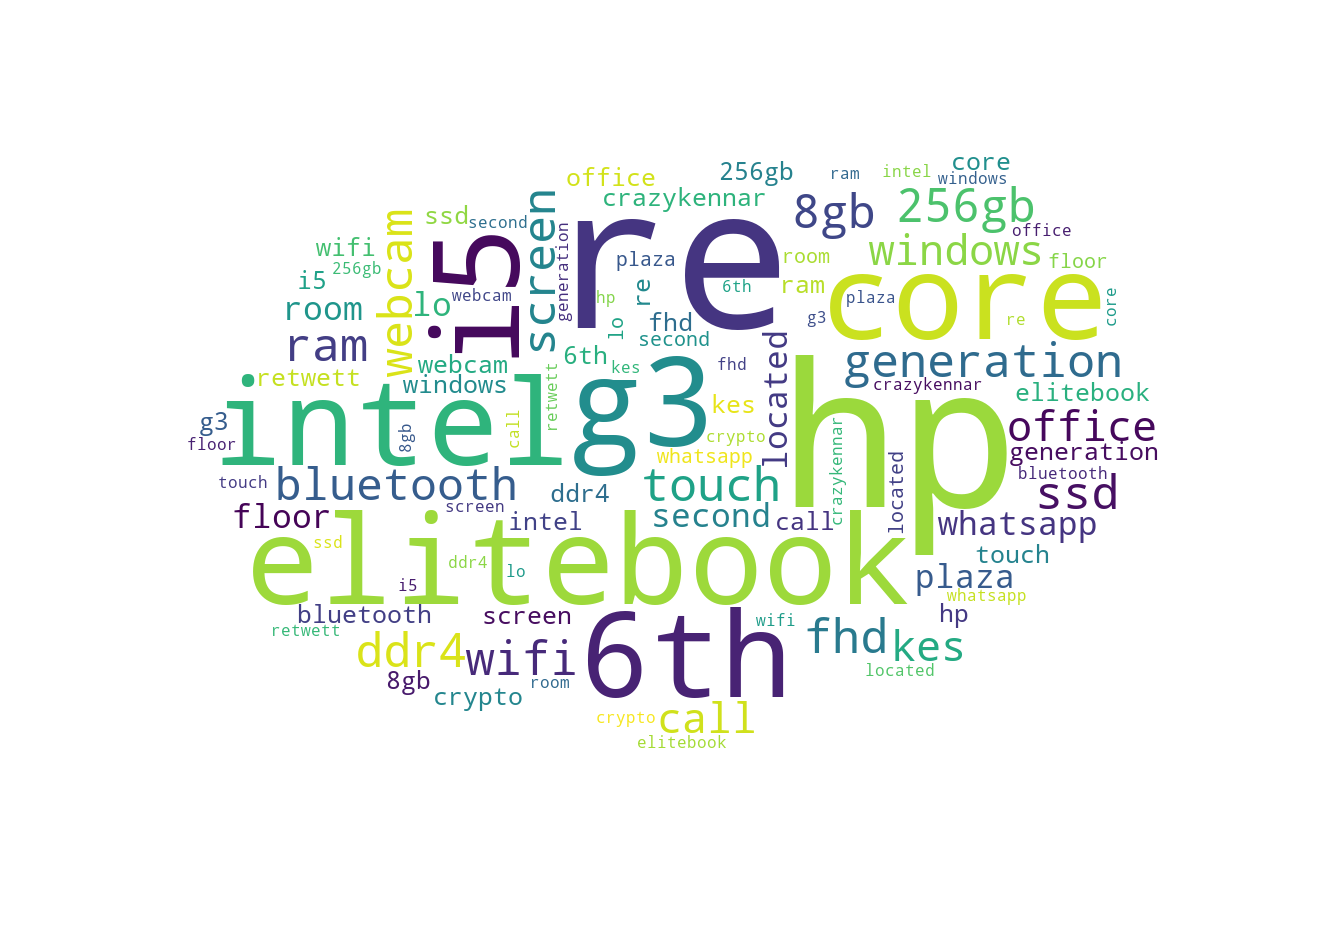

In [31]:
from util import create_word_cloud
create_word_cloud(tweet_list_df["cleaned"].values, "all")
create_word_cloud(tweet_list_df_positive["cleaned"].values, "positive")
create_word_cloud(tweet_list_df_negative["cleaned"].values, "negative")
create_word_cloud(tweet_list_df_neutral["cleaned"].values, "neutral")

### Text Insights

In [32]:
#Calculating tweet's lenght and word count
tweet_list_df['text_len'] = tweet_list_df['cleaned'].astype(str).apply(len)
tweet_list_df['text_word_count'] = tweet_list_df['cleaned'].apply(lambda x: len(str(x).split()))

In [33]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_len.mean()),2)

,text_len
sentiment,
neutral,257.0
positive,129.0


In [34]:
round(pd.DataFrame(tweet_list_df.groupby("sentiment").text_word_count.mean()),2)

,text_word_count
sentiment,
neutral,46.0
positive,19.5


## Saving Output Tweets File to Drive

In [35]:
tweet_list_df.to_csv("./outputs/c2_sentimentanalysis_output.csv", sep=',', encoding='UTF-8')
tweet_list_df.head(5)

,text,cleaned,polarity,subjectivity,sentiment,neg,neu,pos,compound,text_len,text_word_count
0,@crazy_kennar asha wa plug🤣🤣.... We've got ama...,kennar asha wa plug we ve got amazing offers ...,0.233333,0.433333,positive,0.048,0.758,0.194,0.7003,198,28
1,Hp Elitebook 840 G3\nIntel®️ Core™️ i5 6th gen...,hp elitebook 840 g3 intel core i5 6th generati...,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000,257,46
2,How well do you know #CrazyKennar?\n\nFull Vid...,how well do you know crazykennar full video on...,0.350000,0.550000,positive,0.000,0.826,0.174,0.2732,60,11
